# Yelp Rating Prediction FCNN

Author: Rahul Gupta

Goal of the project is to develop an FCNN (Fully Connected Neural Network) to predict Yelp rating scores based on the text data from user-written reviews.

## Data Loading
Need to first load, understand, and preprocess data for the neural network.

In [1]:
import numpy as np
import pandas as pd

# Starter code
review = pd.read_json('./data/yelp_academic_dataset_review.json', lines=True, nrows= 1000000)
business = pd.read_json('./data/yelp_academic_dataset_business.json', lines=True, nrows= 1000000)

In [2]:
review.dropna(inplace=True)
print(review.shape)
review.head()

(1000000, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [3]:
business.dropna(inplace=True)
print(business.shape)
business.head()

(117618, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


In [4]:
# Drop businesses with less than 20 reviews
business_to_drop = business[business['review_count'] < 20]

business_filtered = business[business['review_count'] >= 20]

# Remove reviews for businesses that aren't in business_filtered
review_filtered = review[review['business_id'].isin(business_filtered['business_id']) == True]

## Preprocess

Join the tables together such that we have a business and all the reviews for each business in one row.

We'll use TFIDF on all the reviews for a business to predict the business's rating.

In [5]:
from scipy.stats import zscore

df_review_agg = review_filtered.groupby('business_id')['text'].sum()

df_grouped = pd.DataFrame({
    'business_id': df_review_agg.index, 
    'all_reviews': df_review_agg.values,
    })

# Join the business star ratings w/ business IDs
# Normalize the star ratings
df_grouped = df_grouped.merge(business_filtered[['business_id', 'stars']], on='business_id', how='inner')
df_grouped['stars'] = zscore(df_grouped['stars'])

print(df_grouped.shape)
df_grouped.head()

(10769, 3)


,business_id,all_reviews,stars
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,1.055696
1,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,1.055696
2,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,1.055696
3,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,0.442790
4,-0E7laYjwZxEAQPhFJXxow,I recently visited this dealership because the...,-0.170116


## Applying TFIDF
Use TFIDF on review text to extract relevant features. Ignore stop words.

In [6]:
import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

In [7]:
vectorizer.get_feature_names_out()[:40]

array(['10', '20', '30', 'able', 'absolutely', 'actually', 'amazing',
       'area', 'ask', 'asked', 'atmosphere', 'attentive', 'away',
       'awesome', 'bad', 'bar', 'beef', 'beer', 'best', 'better', 'big',
       'bit', 'bread', 'breakfast', 'burger', 'business', 'busy',
       'called', 'came', 'car', 'care', 'check', 'cheese', 'chicken',
       'city', 'clean', 'coffee', 'cold', 'come', 'coming'], dtype=object)

## Train Test Split
Splitting the training and resting data (80/20)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## RMSE Function

In [9]:
from sklearn import metrics

# Predict and measure RMSE
def print_rsme(model, x_test, y_test):
    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    
    print("RMSE Score: {}".format(score))


## Lift Chart Function

In [10]:
# Function from lab #4
import matplotlib.pyplot as plt

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Plot the chart
# chart_regression(pred.flatten(),y_test, sort=True)

## Basic FCNN
No dropout layers, just a basic fully connected neural network.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

basic_fcnn_model = Sequential()

basic_fcnn_model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
basic_fcnn_model.add(Dense(250, activation='relu'))
basic_fcnn_model.add(Dense(125, activation='relu'))
basic_fcnn_model.add(Dense(60, activation='relu'))
basic_fcnn_model.add(Dense(30, activation='relu'))
basic_fcnn_model.add(Dense(15, activation='relu'))
basic_fcnn_model.add(Dense(1))

basic_fcnn_model.compile(loss='mean_squared_error', optimizer='adam')

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
basic_fcnn_model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)



c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 4s - 14ms/step - loss: 0.3677 - val_loss: 0.2763
Epoch 2/1000
270/270 - 2s - 6ms/step - loss: 0.2578 - val_loss: 0.2476
Epoch 3/1000
270/270 - 1s - 6ms/step - loss: 0.2170 - val_loss: 0.2376
Epoch 4/1000
270/270 - 2s - 6ms/step - loss: 0.1781 - val_loss: 0.2580
Epoch 5/1000
270/270 - 2s - 6ms/step - loss: 0.1517 - val_loss: 0.2514
Epoch 6/1000
270/270 - 2s - 6ms/step - loss: 0.1252 - val_loss: 0.2346
Epoch 7/1000
270/270 - 2s - 7ms/step - loss: 0.1029 - val_loss: 0.2367
Epoch 8/1000
270/270 - 2s - 6ms/step - loss: 0.0885 - val_loss: 0.2360
Epoch 9/1000
270/270 - 2s - 6ms/step - loss: 0.0756 - val_loss: 0.2483
Epoch 10/1000
270/270 - 2s - 6ms/step - loss: 0.0668 - val_loss: 0.2456
Epoch 11/1000
270/270 - 2s - 6ms/step - loss: 0.0577 - val_loss: 0.2480
Epoch 11: early stopping


In [12]:
print_rsme(basic_fcnn_model, x_test, y_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE Score: 0.498018004491008


## Adjusting Hyperparameters
We'll be using the slower learning rate adam optimizer from before, since it yielded slightly lower RSME.


### Changing Max Features
Adjusting the max number of features for TFIDF

In [15]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=500, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(1000, input_dim=x.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.0001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 5s - 18ms/step - loss: 0.4403 - val_loss: 0.2279
Epoch 2/1000
270/270 - 3s - 10ms/step - loss: 0.2397 - val_loss: 0.2316
Epoch 3/1000
270/270 - 3s - 11ms/step - loss: 0.2007 - val_loss: 0.2199
Epoch 4/1000
270/270 - 3s - 10ms/step - loss: 0.1738 - val_loss: 0.2543
Epoch 5/1000
270/270 - 3s - 10ms/step - loss: 0.1422 - val_loss: 0.2225
Epoch 6/1000
270/270 - 3s - 10ms/step - loss: 0.1117 - val_loss: 0.2124
Epoch 7/1000
270/270 - 3s - 10ms/step - loss: 0.0909 - val_loss: 0.2219
Epoch 8/1000
270/270 - 3s - 10ms/step - loss: 0.0718 - val_loss: 0.2334
Epoch 9/1000
270/270 - 3s - 11ms/step - loss: 0.0561 - val_loss: 0.2268
Epoch 10/1000
270/270 - 3s - 10ms/step - loss: 0.0468 - val_loss: 0.2208
Epoch 11/1000
270/270 - 3s - 10ms/step - loss: 0.0384 - val_loss: 0.2291
Epoch 11: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE Score: 0.47859797158249917


### Use SGD

In [ ]:
# Using SGD instead of Adam

vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=500, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(1000, input_dim=x.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1))

sgd_modified = optimizers.SGD(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=sgd_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 3s - 11ms/step - loss: 1.0019 - val_loss: 0.9832
Epoch 2/1000
270/270 - 2s - 8ms/step - loss: 0.9988 - val_loss: 0.9782
Epoch 3/1000
270/270 - 2s - 9ms/step - loss: 0.9878 - val_loss: 0.9607
Epoch 4/1000
270/270 - 2s - 9ms/step - loss: 0.9675 - val_loss: 0.9376
Epoch 5/1000
270/270 - 2s - 8ms/step - loss: 0.9418 - val_loss: 0.9073
Epoch 6/1000
270/270 - 2s - 9ms/step - loss: 0.9053 - val_loss: 0.8644
Epoch 7/1000
270/270 - 2s - 8ms/step - loss: 0.8530 - val_loss: 0.8026
Epoch 8/1000
270/270 - 2s - 8ms/step - loss: 0.7804 - val_loss: 0.7148
Epoch 9/1000
270/270 - 2s - 8ms/step - loss: 0.6850 - val_loss: 0.6080
Epoch 10/1000
270/270 - 2s - 8ms/step - loss: 0.5740 - val_loss: 0.5029
Epoch 11/1000
270/270 - 2s - 8ms/step - loss: 0.4703 - val_loss: 0.4032
Epoch 12/1000
270/270 - 2s - 9ms/step - loss: 0.3974 - val_loss: 0.3447
Epoch 13/1000
270/270 - 2s - 8ms/step - loss: 0.3554 - val_loss: 0.3279
Epoch 14/1000
270/270 - 2s - 8ms/step - loss: 0.3312 - val_loss: 0.3008


### Tanh Instead of RELU
Changing the activation function

In [38]:
model = Sequential()

model.add(Dense(1000, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(500, activation='tanh'))
model.add(Dense(250, activation='tanh'))
model.add(Dense(125, activation='tanh'))
model.add(Dense(60, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(15, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 6s - 23ms/step - loss: 0.3451 - val_loss: 0.2492
Epoch 2/1000
270/270 - 4s - 13ms/step - loss: 0.2462 - val_loss: 0.2325
Epoch 3/1000
270/270 - 4s - 13ms/step - loss: 0.2255 - val_loss: 0.2407
Epoch 4/1000
270/270 - 4s - 13ms/step - loss: 0.2046 - val_loss: 0.2592
Epoch 5/1000
270/270 - 3s - 13ms/step - loss: 0.2039 - val_loss: 0.2389
Epoch 6/1000
270/270 - 4s - 14ms/step - loss: 0.1844 - val_loss: 0.2461
Epoch 7/1000
270/270 - 4s - 13ms/step - loss: 0.1795 - val_loss: 0.2538
Epoch 7: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE Score: 0.5037813976571462


### Smaller Number of Layers and Neurons

In [17]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=1000, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 3s - 12ms/step - loss: 0.3140 - val_loss: 0.2256
Epoch 2/1000
270/270 - 2s - 7ms/step - loss: 0.1888 - val_loss: 0.2178
Epoch 3/1000
270/270 - 2s - 7ms/step - loss: 0.1381 - val_loss: 0.2256
Epoch 4/1000
270/270 - 2s - 7ms/step - loss: 0.0951 - val_loss: 0.2319
Epoch 5/1000
270/270 - 2s - 7ms/step - loss: 0.0700 - val_loss: 0.2290
Epoch 6/1000
270/270 - 2s - 7ms/step - loss: 0.0509 - val_loss: 0.2437
Epoch 7/1000
270/270 - 2s - 7ms/step - loss: 0.0375 - val_loss: 0.2308
Epoch 7: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE Score: 0.48042382537307265


### Smaller Number of Layers and Neurons w/ Dropout
Also using 2k words for vectorizer

In [18]:
from tensorflow.keras.layers import Dropout

vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=2000, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 4s - 17ms/step - loss: 0.3300 - val_loss: 0.2212
Epoch 2/1000
270/270 - 3s - 11ms/step - loss: 0.1842 - val_loss: 0.2147
Epoch 3/1000
270/270 - 3s - 11ms/step - loss: 0.1239 - val_loss: 0.2213
Epoch 4/1000
270/270 - 3s - 11ms/step - loss: 0.0865 - val_loss: 0.2188
Epoch 5/1000
270/270 - 3s - 11ms/step - loss: 0.0615 - val_loss: 0.2213
Epoch 6/1000
270/270 - 3s - 11ms/step - loss: 0.0494 - val_loss: 0.2194
Epoch 7/1000
270/270 - 3s - 11ms/step - loss: 0.0400 - val_loss: 0.2225
Epoch 7: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE Score: 0.4716776706986138


### Testing different dropout values

In [19]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 4s - 16ms/step - loss: 0.3634 - val_loss: 0.2094
Epoch 2/1000
270/270 - 3s - 11ms/step - loss: 0.2176 - val_loss: 0.2018
Epoch 3/1000
270/270 - 3s - 11ms/step - loss: 0.1759 - val_loss: 0.2085
Epoch 4/1000
270/270 - 3s - 10ms/step - loss: 0.1376 - val_loss: 0.2203
Epoch 5/1000
270/270 - 3s - 10ms/step - loss: 0.1182 - val_loss: 0.2156
Epoch 6/1000
270/270 - 3s - 11ms/step - loss: 0.1014 - val_loss: 0.2301
Epoch 7/1000
270/270 - 3s - 10ms/step - loss: 0.0895 - val_loss: 0.2186
Epoch 7: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE Score: 0.46753157969092063


### Reduce by 1 layer

In [20]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

adam_modified = optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=adam_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 4s - 14ms/step - loss: 0.3612 - val_loss: 0.2094
Epoch 2/1000
270/270 - 3s - 10ms/step - loss: 0.2214 - val_loss: 0.2040
Epoch 3/1000
270/270 - 3s - 10ms/step - loss: 0.1752 - val_loss: 0.2191
Epoch 4/1000
270/270 - 3s - 10ms/step - loss: 0.1453 - val_loss: 0.2127
Epoch 5/1000
270/270 - 3s - 10ms/step - loss: 0.1215 - val_loss: 0.2079
Epoch 6/1000
270/270 - 3s - 10ms/step - loss: 0.1061 - val_loss: 0.2157
Epoch 7/1000
270/270 - 3s - 10ms/step - loss: 0.0935 - val_loss: 0.2129
Epoch 7: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE Score: 0.46142682447009553


### 10k TFIDF Features w/ SGD

In [21]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=10000, min_df=1)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

sgd_modified = optimizers.SGD(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=sgd_modified)

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
270/270 - 5s - 17ms/step - loss: 1.0050 - val_loss: 0.9843
Epoch 2/1000
270/270 - 4s - 14ms/step - loss: 1.0021 - val_loss: 0.9811
Epoch 3/1000
270/270 - 4s - 15ms/step - loss: 0.9978 - val_loss: 0.9773
Epoch 4/1000
270/270 - 4s - 14ms/step - loss: 0.9953 - val_loss: 0.9730
Epoch 5/1000
270/270 - 4s - 15ms/step - loss: 0.9903 - val_loss: 0.9678
Epoch 6/1000
270/270 - 4s - 14ms/step - loss: 0.9873 - val_loss: 0.9624
Epoch 7/1000
270/270 - 4s - 14ms/step - loss: 0.9809 - val_loss: 0.9561
Epoch 8/1000
270/270 - 4s - 15ms/step - loss: 0.9752 - val_loss: 0.9489
Epoch 9/1000
270/270 - 4s - 15ms/step - loss: 0.9665 - val_loss: 0.9410
Epoch 10/1000
270/270 - 4s - 14ms/step - loss: 0.9591 - val_loss: 0.9323
Epoch 11/1000
270/270 - 4s - 14ms/step - loss: 0.9507 - val_loss: 0.9225
Epoch 12/1000
270/270 - 4s - 15ms/step - loss: 0.9406 - val_loss: 0.9116
Epoch 13/1000
270/270 - 4s - 14ms/step - loss: 0.9305 - val_loss: 0.8997
Epoch 14/1000
270/270 - 4s - 15ms/step - loss: 0.9199 - val_

In [23]:
model.save('model_sgd_dropout_044.keras')

## Evaluation

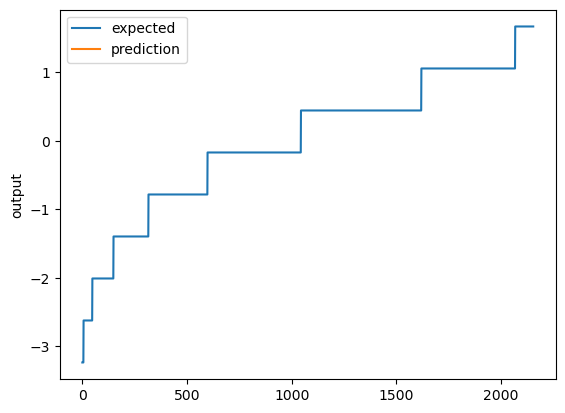

In [24]:
chart_regression(None, y_test, sort=True)

270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


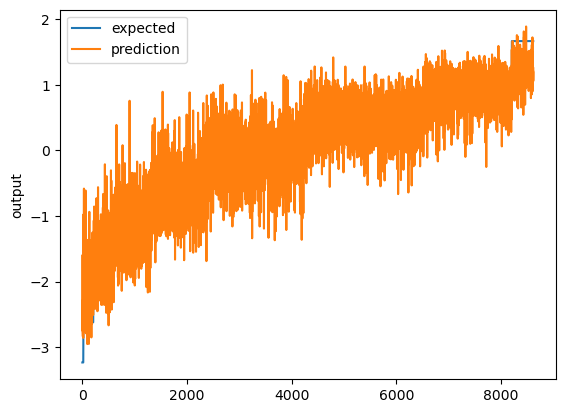

In [25]:
train_pred = model.predict(x_train)
chart_regression(train_pred.flatten(), y_train, sort=True)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


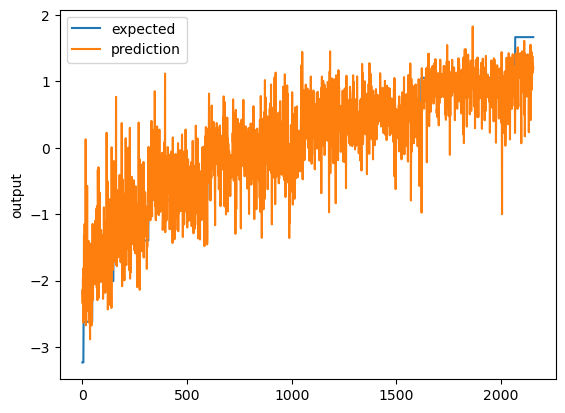

In [26]:
pred = model.predict(x_test)
chart_regression(pred.flatten(), y_test, sort=True)

## Predictions of 5 Businesses
Try the best (TFIDF only) model on 5 businesses

In [27]:
df_5 = df_grouped.merge(business_filtered[['name', 'business_id']], on='business_id', how='inner')
df_5['stars'] = zscore(df_grouped['stars'])

df_5 = df_5[:5]

print(df_5.shape)
df_5

(5, 4)


,business_id,all_reviews,stars,name
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,1.055696,Chris's Sandwich Shop
1,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,1.055696,Family Vision Center
2,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,1.055696,Washoe Metal Fabricating
3,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,0.442790,Stewart's De Rooting & Plumbing
4,-0E7laYjwZxEAQPhFJXxow,I recently visited this dealership because the...,-0.170116,AutoNation Cadillac Port Richey


In [28]:
# NOT FIT TRANSFROM, just transform, we fitted already during prev. TFIDF

x_5 = vectorizer.transform(df_5['all_reviews'])
y_5 = df_5[['stars']].to_numpy()

x_5

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2688 stored elements and shape (5, 10000)>

In [29]:
print(x_5.shape)
print(x_test.shape)

pred = model.predict(x_5)
pred

(5, 10000)
(2154, 10000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


array([[ 1.0229434 ],
       [ 1.125744  ],
       [ 0.9006074 ],
       [ 0.07913205],
       [-0.5493689 ]], dtype=float32)

In [30]:
print(df_5['stars'])
print(pred)

0    1.055696
1    1.055696
2    1.055696
3    0.442790
4   -0.170116
Name: stars, dtype: float64
[[ 1.0229434 ]
 [ 1.125744  ]
 [ 0.9006074 ]
 [ 0.07913205]
 [-0.5493689 ]]


## Extra Feature - is_open
Can the business being open or not help with our score prediction?

In [39]:
df_extra = df_grouped.merge(business_filtered[['business_id', 'is_open']], on='business_id', how='inner')
df_extra['stars'] = zscore(df_grouped['stars'])

print(df_extra.shape)
df_extra.head()

(10769, 4)


,business_id,all_reviews,stars,is_open
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,1.055696,0
1,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,1.055696,1
2,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,1.055696,1
3,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,0.442790,1
4,-0E7laYjwZxEAQPhFJXxow,I recently visited this dealership because the...,-0.170116,1


In [40]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=2000, min_df=1)

x = vectorizer.fit_transform(df_extra['all_reviews'])
print(x.shape)

(10769, 2000)


In [41]:
x_is_open = df_extra[['is_open']].to_numpy()
x = x.toarray()
print(x_is_open.shape)

x = np.hstack([x, x_is_open])

print(x.shape)  

y = df_grouped[['stars']].to_numpy()

(10769, 1)
(10769, 2001)


In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [43]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

Epoch 1/1000


c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


270/270 - 4s - 14ms/step - loss: 0.3707 - val_loss: 0.2083
Epoch 2/1000
270/270 - 3s - 9ms/step - loss: 0.2266 - val_loss: 0.2096
Epoch 3/1000
270/270 - 3s - 9ms/step - loss: 0.1825 - val_loss: 0.2087
Epoch 4/1000
270/270 - 3s - 9ms/step - loss: 0.1534 - val_loss: 0.2080
Epoch 5/1000
270/270 - 3s - 9ms/step - loss: 0.1288 - val_loss: 0.2149
Epoch 6/1000
270/270 - 3s - 9ms/step - loss: 0.1103 - val_loss: 0.2174
Epoch 7/1000
270/270 - 3s - 9ms/step - loss: 0.1017 - val_loss: 0.2141
Epoch 8/1000
270/270 - 3s - 9ms/step - loss: 0.0901 - val_loss: 0.2184
Epoch 9/1000
270/270 - 2s - 9ms/step - loss: 0.0821 - val_loss: 0.2128
Epoch 9: early stopping
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE Score: 0.4612722171846503
